# 2D Bicopter (Quadcopter)

We consider the 2D (vertical $z$ and horizontal axis $y$) quadcopter problem, and consider the following dynamics


State: $$[y, z, v_y, v_z]$$

Near hover Dynamics:
$$\begin{bmatrix}\dot y \\ \dot z \\ \dot v_y\\ \dot v_z\end{bmatrix} = \begin{bmatrix}v_x \\ v_y \\ -T \sin(\phi) \\ T \cos(\phi) - g\end{bmatrix}, \text{with } u=[\phi, T]$$


Approximation of near hover Dynamics: 
$$\begin{bmatrix}\dot y \\ \dot z \\ \dot v_y \\ \dot v_z\end{bmatrix}=\dot{X}=\begin{bmatrix}v_y \\ v_z \\-g\tan(\phi) \\ T-g\end{bmatrix}=\begin{bmatrix}v_y \\ v_z \\ -gu_1 \\ u_2 - g\end{bmatrix}, \text{with } u=[\tan(\phi), T]$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:49:32) \n[GCC 12.3.0]'

In [3]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '20',
    'text.usetex': False,   # Toggle to true for official LaTeX output
    'pgf.rcfonts': False,
    'lines.linewidth': 4.,
})

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import numpy as np
import seaborn as sns

import matplotlib
import pickle as pkl
import pandas as pd

from scipy.interpolate import interp1d
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

In [5]:
import hj_reachability as hj
import cbf_opt
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF, SlackifiedControlAffineASIF, BatchedDynamics
from experiment_wrapper import RolloutTrajectory, StateSpaceExperiment, TimeSeriesExperiment

from refine_cbfs import HJControlAffineDynamics, TabularControlAffineCBF, TabularTVControlAffineCBF, utils

from quad_2d.animate_quad import animate_multi_planar_quad, get_drone

## Setup Problem (dynamics, environment and CBF)

### Dynamics

In [6]:
class CrazyflieDynamics(ControlAffineDynamics):
    """
    Simplified dynamics, and we need to convert controls from phi to tan(phi)"""
    STATES = ["y", "z", "v_y", "v_z"]
    CONTROLS = ["tan(phi)", "T"]
    def __init__(self, params, test=True, **kwargs):
        self.g = params.get("g", 9.81)
        super().__init__(params, test, **kwargs)
    
    def open_loop_dynamics(self, state, time: float = 0.0):
        return jnp.array([state[2], state[3], 0.0, -self.g])
    
    def f(self, state, control, time=0.0):
        return self.open_loop_dynamics(state, time) + self.control_matrix(state, time) @ control

    def control_matrix(self, state, time: float = 0.0):
        return jnp.array([[0.0, 0.0], [0.0, 0.0], [self.g, 0.0], [0.0, 1.0]])
    
    def disturbance_jacobian(self, state, time: float = 0.0):
        return jnp.expand_dims(jnp.zeros(4), axis=-1)
    
    def state_jacobian(self, state, control, time: float = 0.0):
        return jax.jacfwd(lambda x: self.__call__(x, control, time))(state)
    

In [7]:
dyn = CrazyflieDynamics({'dt': 0.01}, test=False)
batched_dyn = BatchedDynamics(dyn)
umax = jnp.array([jnp.tan(np.pi / 6), 1.5 * 9.81])
umin = jnp.array([-jnp.tan(np.pi / 6), 0.0])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Environment:
### Boundary of grid
Boundary of grid is defined below by the state domain
### Environment / obstacles
Safe set is delimited by the state space boundary and by obstacles

In [8]:
state_domain = hj.sets.Box(lo=jnp.array([-6., -0.1, -5., -5.]), 
                           hi=jnp.array([6., 4.1, 5., 5.]))
grid_resolution = (31, 31, 25, 25)  
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution)

In [9]:
boundary = np.array([[-5., 5.], [0., 4.], [-10., 10.], [-10., 10.]])
obstacle1 = np.array([[-2., 0.], [1., 3.], [-100., 100.], [-100., 100.]])
obstacle2 = np.array([[1., 3.], [0., 1.], [-100., 100.], [-100., 100.]])
obstacles = [obstacle1, obstacle2]

In [10]:
sdf = utils.build_sdf(boundary, obstacles[:1])
updated_sdf = utils.build_sdf(boundary, obstacles)

In [11]:
sdf_values = hj.utils.multivmap(sdf, jnp.arange(grid.ndim))(grid.states)
updated_sdf_values = hj.utils.multivmap(updated_sdf, jnp.arange(grid.ndim))(grid.states)

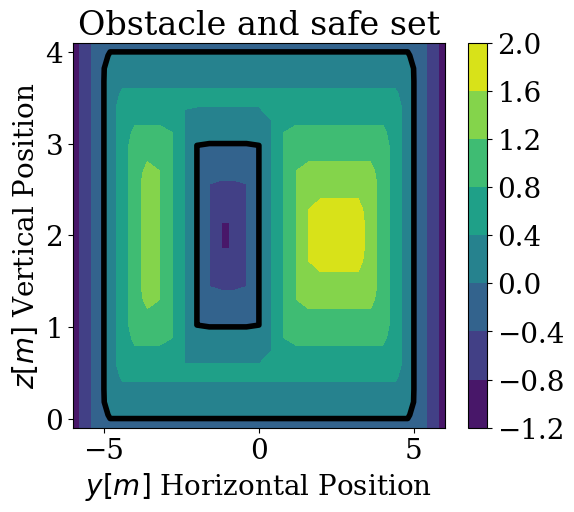

In [12]:
fig = plt.figure(figsize=(6, 5))
f = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], 
                 sdf_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
            sdf_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='k')
plt.colorbar(f)
plt.xlabel("$y [m]$ Horizontal Position")
plt.ylabel("$z [m]$ Vertical Position")
plt.title("Obstacle and safe set");

### Initial Control Barrier Function

In [13]:
class CrazyflieCBF(ControlAffineCBF):
    def __init__(self, dynamics, params, test=False, **kwargs):
        self.scaling = params["scaling"]
        self.center = params["center"]
        self.offset = params["offset"]
        self._vf_grad = jax.vmap(jax.grad(self.vf, argnums=0), in_axes=(0, None))
        super().__init__(dynamics, params, test=False, **kwargs)
    
    def vf(self, state, time=0.0):
        val = (self.offset - jnp.sum(self.scaling * (state - self.center) ** 2, axis=-1))
        return val
        # return jnp.where(val > 0, val, 0.1 * val)
    
    def _grad_vf(self, state, time=0.0):
        return self._vf_grad(state, time)

In [14]:
cbf_cf_params = {"scaling": jnp.array([2.0, 2.0, 1.0, 1.0]), "offset": 2.0, "center": jnp.array([-3.5, 2., 0.0, 0.])}
cbf_cf = CrazyflieCBF(batched_dyn, cbf_cf_params, test=False)

In [15]:
tabular_cbf = TabularControlAffineCBF(batched_dyn, cbf_cf_params, test=False, grid=grid)
tabular_cbf.tabularize_cbf(cbf_cf)

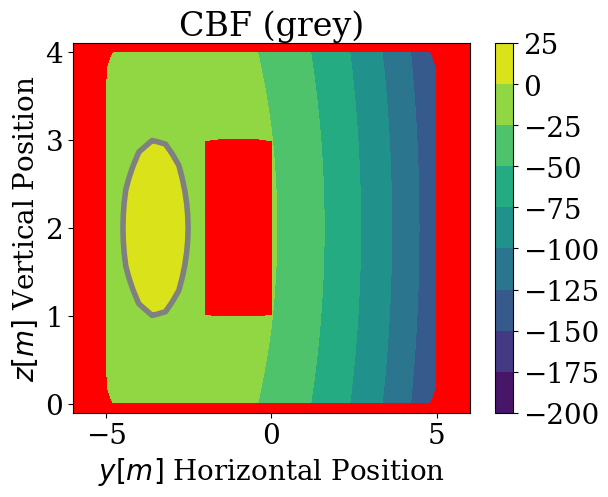

In [16]:
f = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], 
                 tabular_cbf.vf_table[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
            tabular_cbf.vf_table[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='grey')
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
            sdf_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[-10, 0], colors='red')
plt.colorbar(f)
plt.xlabel("$y [m]$ Horizontal Position")
plt.ylabel("$z [m]$ Vertical Position")
plt.title("CBF (grey)");

# refineCBF: Refining a CBF with DP-based reachability

Below we consider a scenario in which we observe an obstacle 1/4 of the time in (hence after 1.25 s)

We still solve the original value function (with less obstacles) until completion for comparison.

We concatenate the original `target_values` with `target_values2` which use different solver settings (due to different obstacles)


Other possibilities for changes:
- Different dynamics (e.g. less control, add disturbance, etc.)

We also consider a minimum distance from the obstacle, which helps with visualization and can also provide robustness against failures

In [17]:
distance_from_obstacle = 0.2

In [18]:
dyn_hjr = HJControlAffineDynamics(dyn, control_space=hj.sets.Box(umin, umax))

backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(sdf_values - distance_from_obstacle))
solver_settings2 = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(updated_sdf_values - distance_from_obstacle))


In [19]:
init_values = tabular_cbf.vf_table
initial_time = 0.
final_time = -5.0
times = jnp.linspace(initial_time, final_time, 51)
target_values = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)
target_values2 = hj.solve(solver_settings2, dyn_hjr, grid, times[len(times) // 4:], target_values[len(times) // 4])
target_values_full = jnp.concatenate([target_values[:len(times) // 4], target_values2])

 50%|#####     |  2.5062/5.0 [00:35<00:37, 15.21s/sim_s]

In [ ]:
sdf_full = jnp.concatenate([sdf_values[None].repeat(len(target_values) // 4, axis=0), updated_sdf_values[None].repeat(len(target_values2), axis=0)])

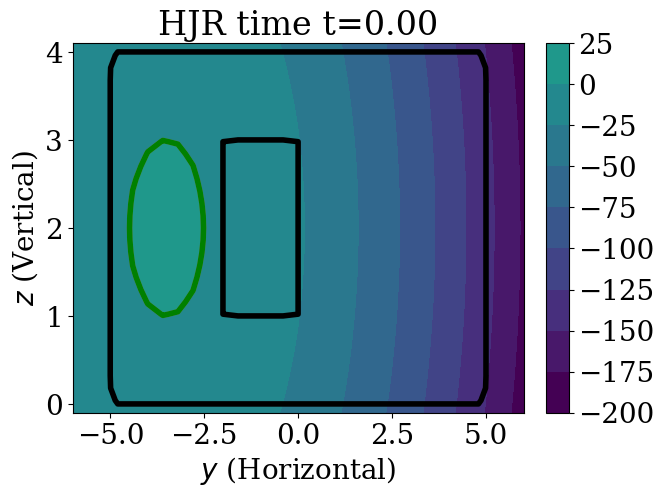

In [ ]:
# Set up the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)

div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

frames = []
for i in range(len(target_values)):
    curvals = target_values_full[i]
    frames.append(curvals)

cv0 = frames[0]
vmax = np.abs(cv0).max()
cf = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
                 cv0[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, vmax=vmax, vmin=-vmax)
ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           tabular_cbf.vf_table[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='grey', linewidths=4)  
cont_sdf = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           sdf_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='k', linewidths=4)
cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           cv0[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='green', linewidths=2)
cb = fig.colorbar(cf, cax=cax)
tx = ax.set_title(f'HJR time $t=0$')
ax.set_xlabel('$y$ (Horizontal)')
ax.set_ylabel('$z$ (Vertical)')
tx = ax.set_title(f'$v_y=0, v_z=0$, HJR time $t=0$')

# Update function to draw contours for a given idi value
def update(idi):
    global cont, cont_sdf
    arr = frames[idi][:, :, grid.shape[2] // 2, grid.shape[3] // 2].T
    arr_sdf = sdf_full[idi][:, :, grid.shape[2] // 2, grid.shape[3] // 2].T
    vmax = np.abs(arr).max()
    # ax.clear()
    cf = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], arr, vmax=vmax, vmin=-vmax)
    cont.collections[0].remove()
    cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
               arr, levels=[0], colors='green')
    cont_sdf.collections[0].remove()
    cont_sdf = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
                          arr_sdf, levels=[0], colors='k', linewidths=4)
    cax.cla()
    fig.colorbar(cf, cax=cax)
    tx.set_text('HJR time t={:.2f}'.format(np.abs(times[idi].item())))


# Animate with idi values from 0 to 11
ani = FuncAnimation(fig, update, frames=range(len(times)))
plt.close()
HTML(ani.to_jshtml())

In [ ]:
# Set up the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)


ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           tabular_cbf.vf_table[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='grey', linewidths=4)  
cont3 = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           sdf_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[-10, 0], colors='red')
cont2 = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           sdf_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='k', linewidths=4)
cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           cv0[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='green', linewidths=2)
ax.set_xlabel('$y$ (Horizontal)')
ax.set_ylabel('$z$ (Vertical)')
tx = ax.set_title(f'$v_y=0, v_z=0$, HJR time $t=0$')

# Update function to draw contours for a given idi value
def update(idi):
    global cont, cont2, cont3
    arr = frames[idi][:, :, grid.shape[2] // 2, grid.shape[3] // 2].T
    arr_sdf = sdf_full[idi][:, :, grid.shape[2] // 2, grid.shape[3] // 2].T
    vmax = np.abs(arr).max()
    # ax.clear()
    cont.collections[0].remove()
    cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
               arr, levels=[0], colors='green')
    cont2.collections[0].remove()
    cont2 = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
                          arr_sdf, levels=[0], colors='k', linewidths=4)
    cont3.collections[0].remove()
    cont3 = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           arr_sdf, levels=[-10, 0], colors='red')
    tx.set_text('$v_y=0, v_z=0$, HJR time t={:.2f}'.format(np.abs(times[idi].item())))


# Animate with idi values from 0 to 11
ani = FuncAnimation(fig, update, frames=range(len(times)));
plt.close()
HTML(ani.to_jshtml())

## Online implementation

### Comparisons
We compare the following algorithms:
- Nominal safety-agnostic control
- Heuristic CBF (what people use in practice!)
- CBVF computed using `refineCBF` from heuristic CBF offline
- Time varying CBVF (Ours)

### Value function evolution

The timescales over which we solved for the value function offline (see above) might not be real-time feasible. Hence we consider it is solved at a different frequency (e.g., artificially slowing down how the value function changes), to test out the framework.

Here we "slow" the reachability updates by a factor 4!

In [ ]:
times_sim = jnp.linspace(0., 20., len(times))
target_values_f = interp1d(times_sim, target_values_full, axis=0)
sdf_values_f = interp1d(times_sim, sdf_full, axis=0)

In [ ]:
tabular_finalized_cbf = TabularControlAffineCBF(batched_dyn, cbf_cf_params, test=False, grid=grid)
tabular_finalized_cbf.vf_table = target_values[-1]

In [ ]:
tv_cbf = TabularTVControlAffineCBF(batched_dyn, cbf_cf_params, test=False, grid=grid)

In [ ]:
tv_cbf.set_vf_table(times_sim, target_values_f)

100%|██████████| 51/51 [00:03<00:00, 14.88it/s]


### Nominal control
We consider an LQR controller for nominal control. If you modify the experiment you can see that an LQR controller with safety filter is safe but can lead to us getting stuck

In [ ]:
x_nom = jnp.array([0.0, 3.0, 0.0, 0.0])
u_nom = jnp.array([0.0, 9.81])
A, B = dyn.linearized_dt_dynamics(x_nom, u_nom)

Q = jnp.diag(jnp.array([1.0, 1.0, 0.1, 0.1]))
R = jnp.diag(jnp.array([1.0, 1.0]))

K = cbf_opt.utils.lqr(A, B, Q, R)

A_cl = A - B @ K
# assert np.all(np.linalg.eigvals(A_cl) < 0).all() 

In [ ]:
nominal_control = lambda u_ref, x_ref, F: lambda x, t: np.atleast_2d(np.clip(u_ref - 
                                (F @ (x - x_ref).T).T, umin, umax))

### Safety filter
We use the slackified version of the safety filter to ensure , we use gurobi as a solver (you need to obtain an academic license, or change the solver to e.g. "ECOS" / "OSQP")

In [ ]:
x_goal = jnp.array([4.0, 1.0, 0.0, 0.0])
u_goal = jnp.array([0.0, 9.81])
import cvxpy as cp
nom_control = nominal_control(u_goal, x_goal, K)
alpha = lambda x: 3.0 * x
tv_cbvf_asif = SlackifiedControlAffineASIF(batched_dyn, tv_cbf, test=False, alpha=alpha, nominal_policy=nom_control,
                                           umin=umin, umax=umax, solver=cp.GUROBI)

cbvf_asif = SlackifiedControlAffineASIF(batched_dyn, tabular_finalized_cbf, test=False, alpha=alpha, nominal_policy=nom_control,
                                        umin=umin, umax=umax, solver=cp.GUROBI)

cbf_asif = SlackifiedControlAffineASIF(batched_dyn, cbf_cf, test=False, alpha=alpha, nominal_policy=nom_control,
                                       umin=umin, umax=umax, solver=cp.GUROBI)

In [ ]:
x0 = jnp.array([-4.0, 2.0, 0.0, 0.0])
experiment = RolloutTrajectory('quad', start_x=x0, n_sims_per_start=1, t_sim=20.0)

In [ ]:
import logging
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)
results_df = experiment.run(batched_dyn, {"nominal": nom_control, "CBF": cbf_asif, "CBVF": cbvf_asif, "TV_CBVF": tv_cbvf_asif})

Controller rollout:   0%|          | 0/2000 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-25


Controller rollout:  48%|████▊     | 969/2000 [00:13<00:13, 74.49it/s]

In [ ]:
# Find closest time in results_df.t to time_ind
def find_closest_time(df, time_ind):
    return df.t.iloc[df.t.sub(time_ind).abs().idxmin()]


ss_exp = StateSpaceExperiment('quad', x_indices=[0, 1], start_x=x0)
# Set up the figure and axis
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
alphas = [0.1, 0.5, 0.5, 1.0]
nbr_controllers = len(results_df.controller.unique())

plt.legend(results_df.controller.unique())
ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           tabular_cbf.vf_table[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='grey', linewidths=4)  
cont3 = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           sdf_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[-10, 0], colors='red')
cont2 = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           sdf_values[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='k', linewidths=4)
cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           target_values_f(0.0)[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T, levels=[0], colors='green', linewidths=2)
ax.set_xlabel('$y$ (Horizontal)', fontsize=20)
ax.set_ylabel('$z$ (Vertical)', fontsize=20)
tx = ax.set_title('$v_y=0, v_z=0$, HJR time $t=0$')
ss_exp.plot(batched_dyn, results_df, ax=ax, add_direction=False, max_time=0.0, alpha=alphas)
ax.legend(ax.lines[::len(ax.lines) // nbr_controllers], results_df.controller.unique(), loc="upper center", ncol=4, fontsize=20)

# Update function to draw contours for a given idi value
def update(time):
    global cont, cont2, cont3
    arr = target_values_f(time)[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T
    sdf_arr = sdf_values_f(time)[:, :, grid.shape[2] // 2, grid.shape[3] // 2].T
    # ax.clear()
    for line in ax.lines:
        line.remove()
    for patch in ax.patches:
        patch.remove()
    ax.set_prop_cycle(None)
    cont.collections[0].remove()
    cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
               arr, levels=[0], colors='green')
    cont2.collections[0].remove()
    cont2 = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
                            sdf_arr, levels=[0], colors='k', linewidths=4)
    cont3.collections[0].remove()
    cont3 = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
                        sdf_arr, levels=[-10, 0], colors='red')
    ss_exp.plot(batched_dyn, results_df, ax=ax, add_direction=False, max_time=time, alpha=alphas)
    closest_time = find_closest_time(results_df, time)
    curr_vals = results_df[(results_df.t == closest_time) & (results_df.measurement.isin(["y", "z", "tan(phi)"]))].value.values.reshape(nbr_controllers, -1)
    colors = []
    for line in ax.lines[::len(ax.lines) // nbr_controllers]:
        colors.append(line.get_color())
    for i, curr_val in enumerate(curr_vals):
        # get color from prop_cycle 
        get_drone(ax, curr_val[0], curr_val[1], np.arctan(-curr_val[2]), rel_size=0.3, height_scale=0.9, alpha=alphas[i], color=colors[i])
    tx.set_text('$v_y=0, v_z=0$, Simulation time t={:.2f}'.format(np.abs(time)))
    fig.tight_layout()


plt.close()
ani = FuncAnimation(fig, update, frames=np.linspace(0,20,100))
# plt.close()

In [ ]:
from IPython.display import HTML

# Display the animation directly in the notebook
HTML(ani.to_jshtml())

In [ ]:
ani.save("ani.gif", writer="pillow")